# Visual story telling part 2: Capital Metro data

The file capmetro_UT.csv contains data from Austin's own Capital Metro bus network, including shuttles to, from, and around the UT campus. These data track ridership on buses in the UT area. Ridership is measured by an optical scanner that counts how many people embark and alight the bus at each stop. Each row in the data set corresponds to a 15-minute period between the hours of 6 AM and 10 PM, each and every day, from September through November 2018. The variables are:

- timestamp: the beginning of the 15-minute window for that row of data
- boarding: how many people got on board any Capital Metro bus on the UT campus in the specific 15 minute window
- alighting: how many people got off ("alit") any Capital Metro bus on the UT campus in the specific 15 minute window
- day_of_week and weekend: Monday, Tuesday, etc, as well as an indicator for whether it's a weekend.
- temperature: temperature at that time in degrees F
- hour_of_day: on 24-hour time, so 6 for 6 AM, 13 for 1 PM, 14 for 2 PM, etc.
- month: July through December

Your task is to create a figure, or set of related figures, that tell an interesting story about Capital Metro ridership patterns around the UT-Austin campus during the semester in question. Provide a clear annotation/caption for each figure, but the figure(s) should be more or less stand-alone, in that you shouldn't need many, many paragraphs to convey its meaning. Rather, the figure together with a concise caption should speak for itself as far as possible.

You have broad freedom to look at any variables you'd like here -- try to find that sweet spot where you're showing genuinely interesting relationships among more than just two variables, but where the resulting figure or set of figures doesn't become overwhelming/confusing. (Faceting/panel plots might be especially useful here.)

In [8]:
import pandas as pd
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


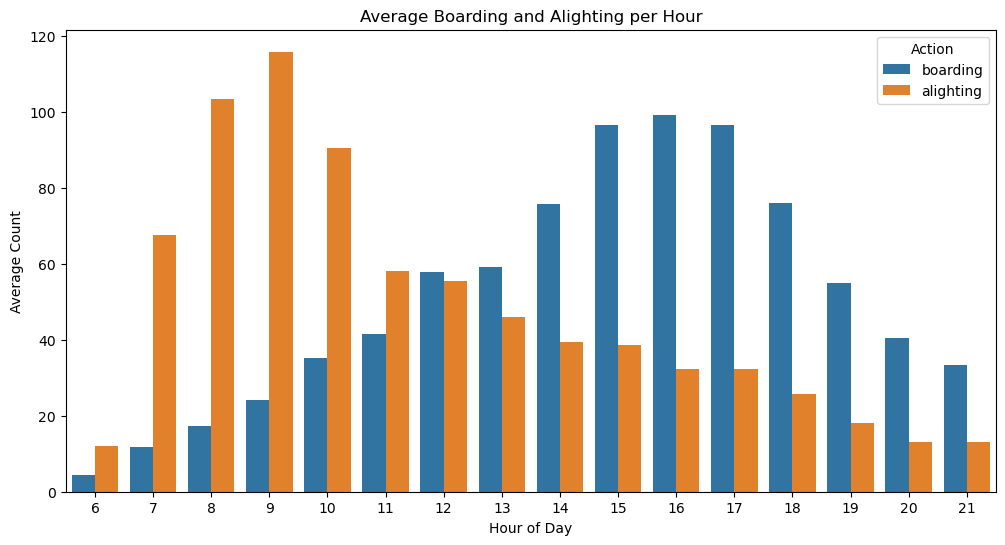

In [9]:
import seaborn as sns

# Group by hour_of_day and calculate mean for boarding and alighting
grouped_by_hour = ut_metro.groupby('hour_of_day')[['boarding', 'alighting']].mean().reset_index()

# Plotting combined bar plot for both boarding and alighting per hour
plt.figure(figsize=(12, 6))
sns.barplot(x='hour_of_day', y='value', hue='variable', data=pd.melt(grouped_by_hour, ['hour_of_day']))
plt.title('Average Boarding and Alighting per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Count')
plt.legend(title='Action')
plt.show()


Students predominantly arrive on campus in the morning and depart in the afternoon. Interestingly, the number of arrivals and departures is equal at noon.

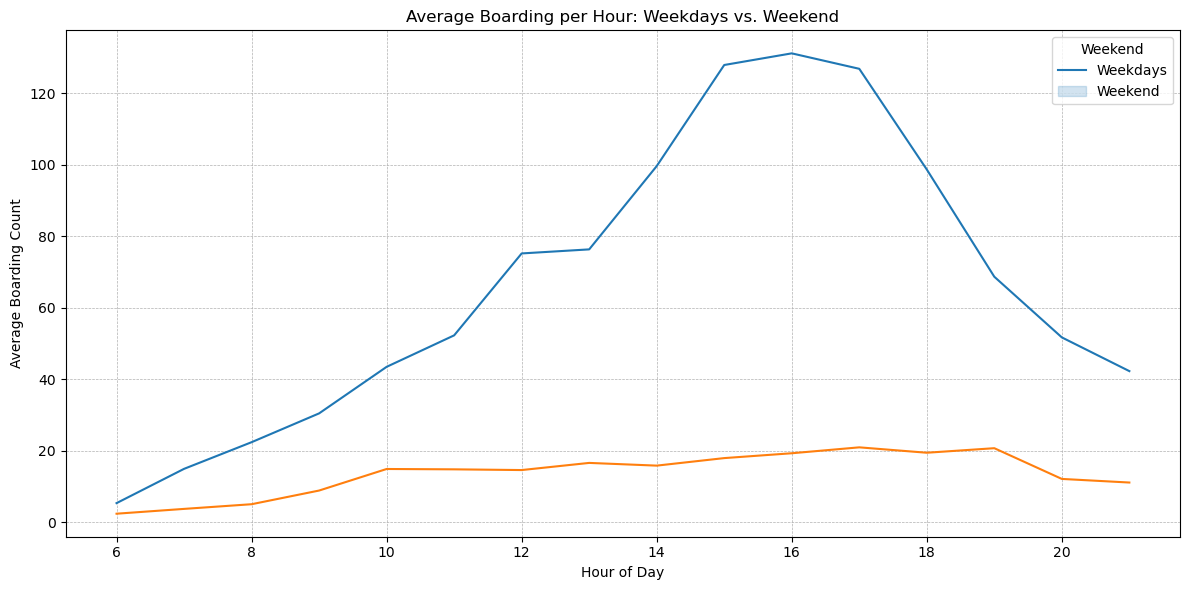

In [14]:
# Grouping by weekend and hour_of_day to calculate mean boarding
grouped_by_weekend_hour = ut_metro.groupby(['weekend', 'hour_of_day'])[['boarding']].mean().reset_index()

# Plotting the patterns for weekend vs. weekdays
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour_of_day', y='boarding', hue='weekend', data=grouped_by_weekend_hour)
plt.title('Average Boarding per Hour: Weekdays vs. Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Average Boarding Count')
plt.legend(title='Weekend', labels=['Weekdays', 'Weekend'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


- The pick-up pattern on weekdays presents a typical double-peak pattern, with one peak in the morning and one in the afternoon.
- On weekends, the boarding pattern is gentler, and the peak time for boarding is later, around noon.

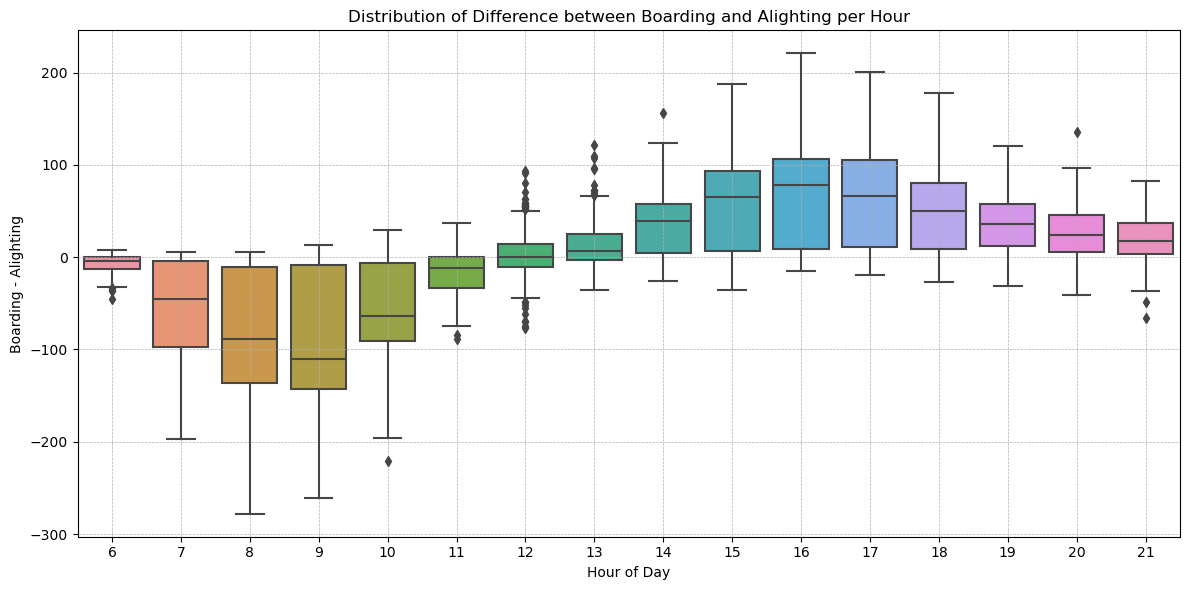

In [15]:
# Calculating the difference between boarding and alighting for each 15-minute interval
ut_metro['boarding_alighting_diff'] = ut_metro['boarding'] - ut_metro['alighting']

# Plotting the distribution of the difference
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour_of_day', y='boarding_alighting_diff', data=ut_metro)
plt.title('Distribution of Difference between Boarding and Alighting per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Boarding - Alighting')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


- The difference between boarding and disembarking is clustered around zero for most hours, meaning that most people disembark shortly after boarding.
- Between 7:00 a.m. and 9:00 a.m., more people board than drop off, meaning more people enter campus during those times.
- Conversely, between 4:00 and 6:00 p.m., more people get off than get on, meaning more people leave campus during this time.

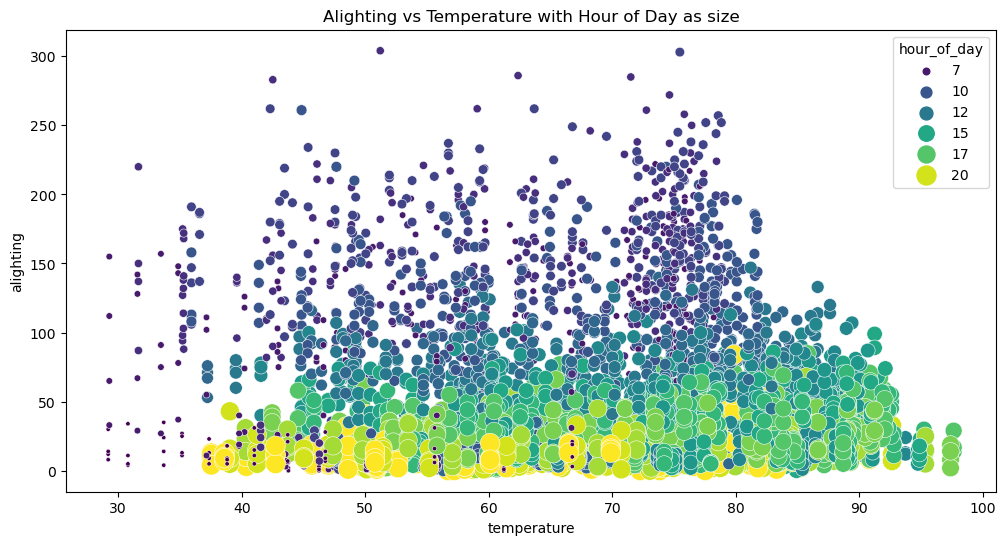

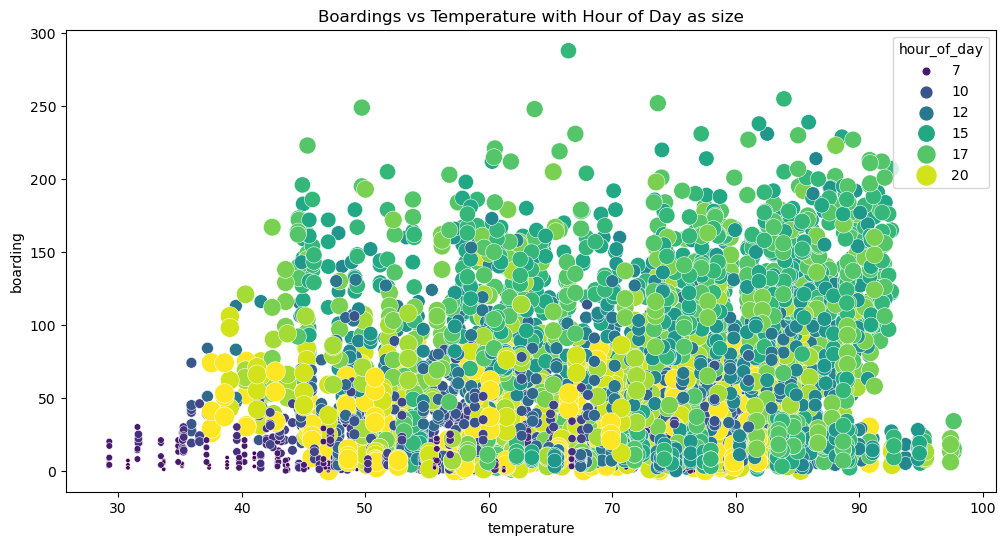

In [11]:
# Visualization 3: Ridership vs Temperature
plt.figure(figsize=(12, 6))
sns.scatterplot(data=ut_metro, x='temperature', y='alighting', hue='hour_of_day', palette='viridis', size='hour_of_day', sizes=(10, 200))
plt.title('Alighting vs Temperature with Hour of Day as size')
plt.show()

# Visualization 3: Ridership vs Temperature
plt.figure(figsize=(12, 6))
sns.scatterplot(data=ut_metro, x='temperature', y='boarding', hue='hour_of_day', palette='viridis', size='hour_of_day', sizes=(10, 200))
plt.title('Boardings vs Temperature with Hour of Day as size')
plt.show()

From the two plots, it's evident that temperature has minimal correlation with the number of boardings and alightings. The first graph illustrates the relationship between temperature and arriving passengers. Remarkably, there's a consistent number of arrivals at 7, suggesting students arrive at school at this time regardless of the temperature. The second plot further underscores that, irrespective of how warm or chilly it is, students predominantly leave school in the afternoon.

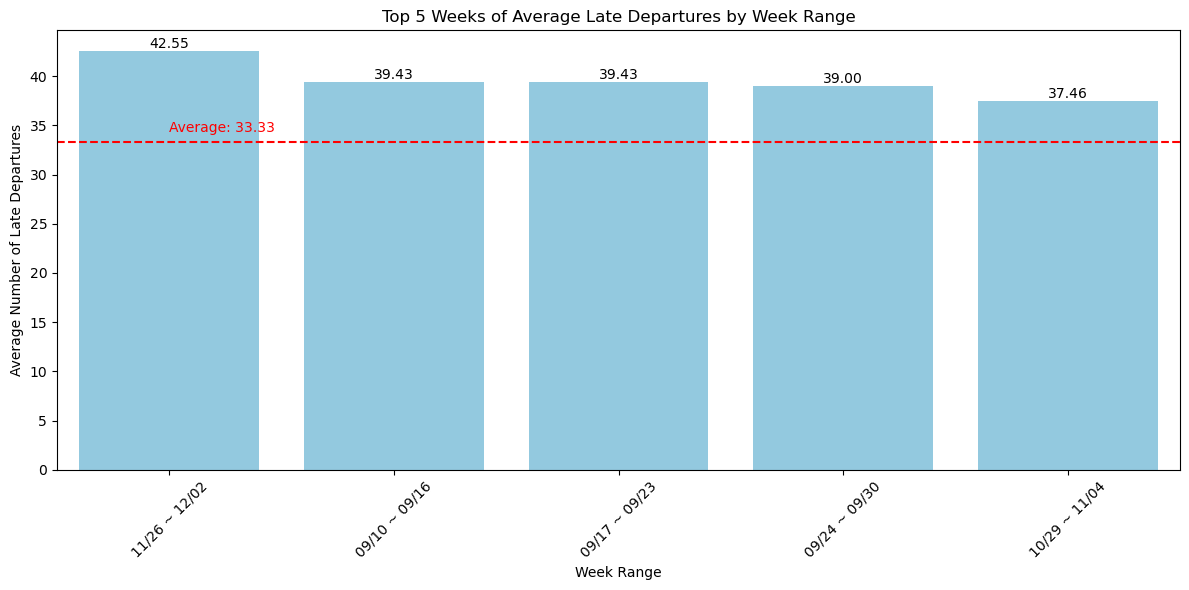

In [16]:
# Ensure that 'timestamp' is of type datetime64
ut_metro['timestamp'] = pd.to_datetime(ut_metro['timestamp'])

# Filter for records after 21:00
ut_metro_late = ut_metro[ut_metro['hour_of_day'] > 20]

# Define average number of student leave the campus
avg_late = ut_metro_late['boarding'].mean()

# Adjust timestamps by subtracting a day, then resample
ut_metro_late.set_index('timestamp', inplace=True)
ut_metro_late_weekly_avg = ut_metro_late.resample('W-SUN')['boarding'].mean().sort_values(ascending=False).head(5).reset_index()

# Adjust the 'timestamp' column back to the start of the week
ut_metro_late_weekly_avg['timestamp'] = ut_metro_late_weekly_avg['timestamp'] - pd.DateOffset(days=6)

# Create a 'week' column for visualization purposes
ut_metro_late_weekly_avg['week'] = ut_metro_late_weekly_avg['timestamp'].dt.strftime('%m/%d') + " ~ " + (ut_metro_late_weekly_avg['timestamp'] + pd.DateOffset(days=6)).dt.strftime('%m/%d')

# Plot setup
plt.figure(figsize=(12, 6))

# Plot the top 10 weeks based on average 'alighting' 
ax = sns.barplot(x='week', y='boarding', data=ut_metro_late_weekly_avg, color='skyblue')

# Draw the average line and annotate
plt.axhline(avg_late, color='r', linestyle='--')
plt.annotate(f'Average: {avg_late:.2f}', xy=(0, avg_late + 1), color='red')

# Annotate each bar with its average value
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Title and labels
plt.title('Top 5 Weeks of Average Late Departures by Week Range')
plt.xlabel('Week Range')
plt.ylabel('Average Number of Late Departures')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


The plot represents the top 5 weeks for late departures. This could be attributed to special activities during these periods, or possibly the final exam season.